# Model evaluation 

## Setup

In [3]:
import os
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
from omegaconf import DictConfig, OmegaConf

output_dir = r"/home/yiting/Documents/GitHub/lightning-pose/outputs"

# # Single model
model_dirs = ["2024-11-27/16-31-40"]
model_names = ["241128"]
save_dir = r'/home/yiting/Documents/LP_projects/LP_241128/model_eval'

# Pose PCA loss
# model_dirs = ["2024-08-12/18-04-44", "2024-08-09/15-12-36"]
# model_names = ["no_pose_pca", "pose_pca"]
# save_dir = r"/home/yiting/Documents/LP_projects/model_eval/pose_pca_loss"

# TCN
# model_dirs = ["2024-08-12/18-04-44", "2024-08-09/16-34-04"]
# model_names = ["no_TCN", "TCN"]
# save_dir = r"/home/yiting/Documents/LP_projects/model_eval/TCN"


### Preparation for multiview datasets (optional)

In [ ]:
# Concatenate data across camera views

# Get view names
view_names = cfg.data.view_names
df_all = pd.DataFrame()
for view in view_names:
    file_path = os.path.join(output_dir, model_dir, "predictions_" + view +".csv")
    df = pd.read_csv(file_path, header=[0, 1, 2], index_col=0)
    df_all = pd.concat([df_all, df])
df_all.to_csv(os.path.join(output_dir, model_dir, "predictions.csv"))

df_error_all = pd.DataFrame()
for view in view_names:
    file_path = os.path.join(output_dir, model_dir, "predictions_" + view +"_pixel_error.csv")
    df = pd.read_csv(file_path, index_col=0)
    df_error_all = pd.concat([df_error_all, df])
df_error_all.to_csv(os.path.join(output_dir, model_dir, "predictions_pixel_error.csv"))

## Labeled Frame Diagnostics

In [2]:
# Load data 
dframes_metrics = defaultdict(dict)
df_data_types = defaultdict(dict)
for model_dir, model_name in zip(model_dirs, model_names):
    # Load hydra configuration file
    cfg = OmegaConf.load(os.path.join(output_dir, model_dir, "config.yaml"))
    # Load prediction files
    prediction_files_all = [filename for filename in os.listdir(os.path.join(output_dir,model_dir)) 
                    if filename.endswith('.csv')]
    # Select predictions.csv and predictions_pixel_error.csv (removing camera view files)
    prediction_files = [filename for filename in prediction_files_all if 'cam' not in str(filename)]
    # Get keypoint names
    keypoint_names = cfg.data.keypoint_names
    # Load evaluation data
    for model_pred_file in prediction_files:
        model_pred_file_path = os.path.join(output_dir, model_dir, model_pred_file)
        model_pred_file_name, ext = os.path.splitext(model_pred_file)
        if "pca" in str(model_pred_file) or "temporal" in str(model_pred_file) or "pixel" in str(model_pred_file):
            dframe = pd.read_csv(model_pred_file_path, index_col=None)
            dframes_metrics[model_name][str(model_pred_file_name)] = dframe
        else:
            dframe = pd.read_csv(model_pred_file_path, header=[1, 2], index_col=0)
            new_df = pd.DataFrame()
            for kp in keypoint_names:
                new_df[kp] = dframe[kp]['likelihood']
            new_df['set'] = dframe.iloc[:,-1]
            dframes_metrics[model_name]["confidence"] = new_df
        df_data_types[model_name] = dframe.iloc[:, -1].unique()
    

### Single Model

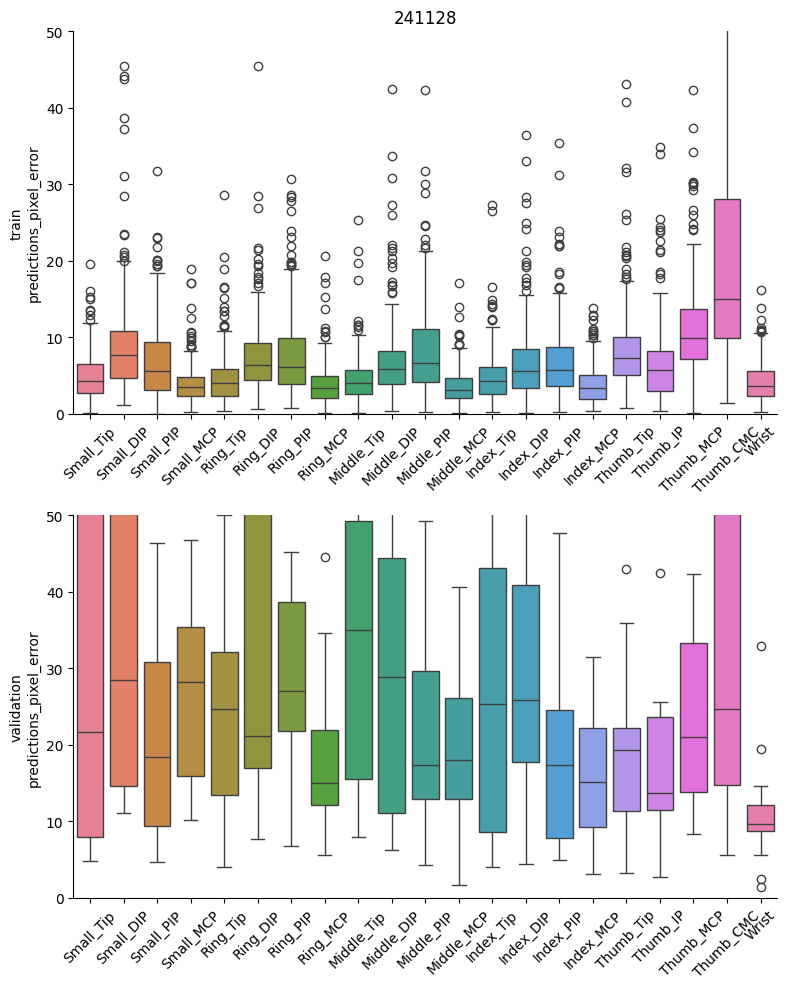

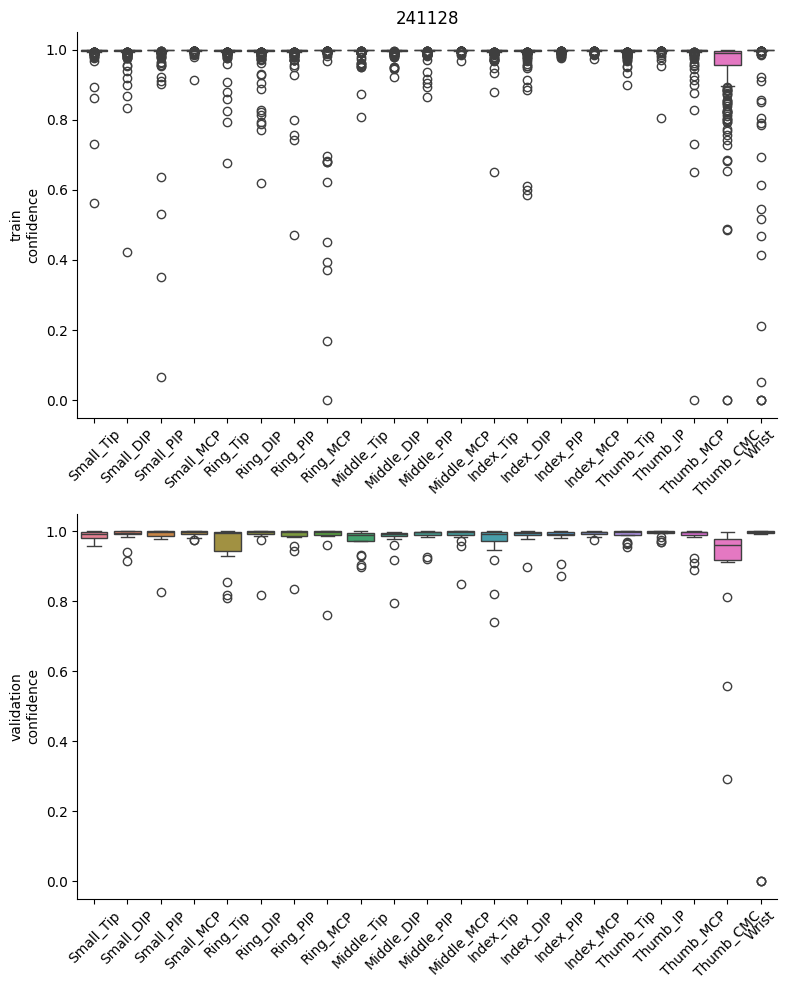

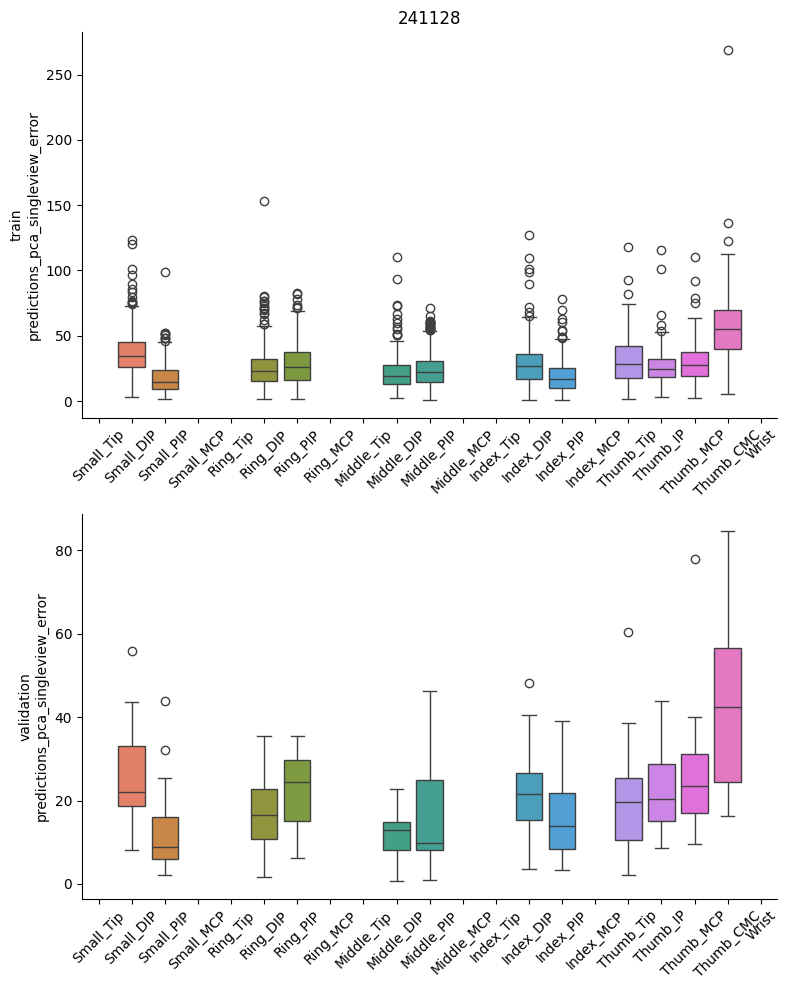

In [5]:
# Plot
metric_names = dframes_metrics[model_names[0]].keys()  # Ensure this retrieves keys correctly
data_types = df_data_types[model_names[0]]  # Assuming `df_data_types` contains lists for each model
model_name = model_names[0]

for me, metric in enumerate(metric_names):
    # Create subplots for each metric
    fig, axs = plt.subplots(len(data_types), 1, figsize=(8, 5 * len(data_types)))
    
    # If there's only one subplot, axs won't be iterable. Convert to a list for consistency
    if len(data_types) == 1:
        axs = [axs]

    df = dframes_metrics[model_name][metric]  # Get the data frame for the current metric

    for d, data_type in enumerate(data_types):
        # Filter the dataframe by data type
        df_data_type = df[df['set'] == data_type]
        df_kp = df_data_type[keypoint_names]  # Select only keypoint-related columns

        # Plot using seaborn's boxplot
        sns.boxplot(data=df_kp, ax=axs[d])  # Use axs[d] instead of [d, 0]

        # Setup title, labels, axes
        axs[d].spines['top'].set_visible(False)
        axs[d].spines['right'].set_visible(False)
        axs[d].tick_params(axis='x', rotation=45)  # Rotate x-tick labels
        axs[d].set_ylabel(data_type + "\n" + metric)
        if "pixel" in metric:
            axs[d].set_ylim(0, 50)
        if d == 0:
            axs[d].set_title(model_name)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure
    save_path = os.path.join(save_dir, f"{metric}.png")
    plt.savefig(save_path)

    # # Close the figure to free memory
    # plt.close(fig)


### Multiple Models

In [ ]:
# Plot 
metric_names = dframes_metrics[model_names[0]].keys()
data_types = df_data_types[model_names[0]]

for me, metric in enumerate(metric_names):
    fig, axs = plt.subplots(len(data_types), len(model_names), figsize=(5*len(model_names), 5*len(data_types)), sharey=True)
    for mo, model_name in enumerate(model_names):
        df = dframes_metrics[model_name][metric]
        for d, data_type in enumerate(data_types):
            df_data_type = df[df['set'] == data_type]
            df_kp = df_data_type[keypoint_names]
            sns.boxplot(data = df_kp, ax=axs[d, mo])
            # Setup title, labels, axes
            axs[d, mo].spines['top'].set_visible(False)
            axs[d, mo].spines['right'].set_visible(False)
            axs[d, mo].tick_params(axis='x', rotation=45)  # Rotate x-tick labels
            axs[d, mo].set_ylabel(data_type + "\n" + metric)
            if "pixel" in metric:
                axs[d, mo].set_ylim(0, 30)
            if d == 0:
                axs[d, mo].set_title(model_name)

            
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(save_dir, metric + ".png")) 